# Data Ingestion

In [1]:
import torch
import numpy as np
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
import scipy.io as sio

kuka_data = sio.loadmat('../data/KukaDirectDynamics.mat')

In [3]:
print(kuka_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'kukatraj1', 'kukatraj10', 'kukatraj2', 'kukatraj3', 'kukatraj4', 'kukatraj5', 'kukatraj6', 'kukatraj7', 'kukatraj8', 'kukatraj9'])


# Preprocessing

In [4]:
import numpy as np

trajectories = {}
total = 0
# Filter out non-trajectory keys and prepare data for training
for key, value in kuka_data.items():
    if key.startswith('kukatraj') and isinstance(value, np.ndarray):
      print(f'{key} - {len(value)}')
      total += len(value)
      trajectories[key] = value

print(f'Total: {total}')

kukatraj1 - 1814
kukatraj10 - 1997
kukatraj2 - 1857
kukatraj3 - 1971
kukatraj4 - 1941
kukatraj5 - 1915
kukatraj6 - 2061
kukatraj7 - 1984
kukatraj8 - 2509
kukatraj9 - 2019
Total: 20068


# Optimisation
---

In [ ]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import optuna
import sys
import utils
sys.path.append('models')

import lstm_model

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- One-time setup for faster optimization ---
# 1. Create a fixed train/validation split
all_keys = sorted(list(trajectories.keys()))
train_keys = all_keys[:8]  # Use 8 trajectories for training
validation_keys = all_keys[8:] # Use 2 for validation

print(f"Optimization - Training on: {train_keys}")
print(f"Optimization - Validating on: {validation_keys}")

# 2. Prepare and scale the training data ONCE
train_traj = np.concatenate([trajectories[key] for key in train_keys], axis=0)
X_train, y_train = train_traj[:, :21], train_traj[:, 21:]

x_scaler_opt = StandardScaler()
y_scaler_opt = StandardScaler()

X_train_scaled = x_scaler_opt.fit_transform(X_train)
y_train_scaled = y_scaler_opt.fit_transform(y_train)
# --- End of one-time setup ---

def objective(trial):
    """
    Revised objective function for Optuna.
    Optimizes for step-by-step error on a fixed validation set.
    """
    # 1. Suggest hyperparameters for the LSTM
    params = {
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'hidden_size': trial.suggest_int('hidden_size', 64, 512, step=32),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True),
        'dropout': trial.suggest_float('dropout', 0.1, 0.7, step=0.1),
        'sequence_length': trial.suggest_int('sequence_length', 10, 80, step=10),
        'epochs': trial.suggest_int('epochs', 50, 200, step=25),
    }

    # 2. Create training sequences from the pre-scaled data
    X_train_seq, y_train_seq = lstm_model.create_sequences(X_train_scaled, y_train_scaled, params['sequence_length'])
    X_train_t = torch.from_numpy(X_train_seq).float().to(device)
    y_train_t = torch.from_numpy(y_train_seq).float().to(device)

    train_dataset = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

    # 3. Instantiate and train the model
    model = lstm_model.LSTMModel(
        input_size=21,
        output_size=14, # Output is scaled, so still 14 features
        hidden_size=params['hidden_size'],
        num_layers=params['n_layers'],
        dropout_rate=params['dropout']
    ).to(device)

    model = lstm_model.train_lstm_model(model, train_loader, params['learning_rate'], params['epochs'])

    # 4. Evaluate on the validation set using step-by-step prediction
    validation_errors = []
    for val_key in validation_keys:
        val_traj = trajectories[val_key]
        X_val, y_val = val_traj[:, :21], val_traj[:, 21:]

        # Use the scaler that was fitted on the main training data
        X_val_scaled = x_scaler_opt.transform(X_val)

        # Predict step-by-step (output is scaled)
        y_pred_scaled = lstm_model.predict_step_by_step_lstm(model, X_val_scaled, y_scaler_opt.transform(y_val), params['sequence_length'])

        # Inverse transform predictions to original scale for error calculation
        y_pred = y_scaler_opt.inverse_transform(y_pred_scaled)

        # Align for metric calculation
        y_val_aligned = y_val[params['sequence_length']:]
        y_pred_aligned = y_pred[params['sequence_length']:]

        # Calculate the nMSE for position (first 7 outputs)
        pos_error = np.mean(utils.nMSE(y_val_aligned[:, :7], y_pred_aligned[:, :7]))
        validation_errors.append(pos_error)

    # Return the average error across the validation trajectories
    return np.mean(validation_errors)

Optimization - Training on: ['kukatraj1', 'kukatraj10', 'kukatraj2', 'kukatraj3', 'kukatraj4', 'kukatraj5', 'kukatraj6', 'kukatraj7']
Optimization - Validating on: ['kukatraj8', 'kukatraj9']


In [11]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40) # n_trials can be adjusted

[I 2025-08-06 14:13:33,066] A new study created in memory with name: no-name-6f1be0c9-4c83-4eff-b192-3c8ed4fdd61a
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
  warnings.warn(
[I 2025-08-06 14:16:20,593] Trial 0 finished with value: 0.4457788268837498 and parameters: {'n_layers': 1, 'hidden_size': 288, 'learning_rate': 1.4529113795625884e-05, 'dropout': 0.7, 'sequence_length': 60, 'epochs': 175}. Best is trial 0 with value: 0.4457788268837498.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
[I 2025-08-06 14:17:47,511] Trial 1 finished with value: 0.5547818748994267 and parameters: {'n_layers':

In [12]:
# After the study is complete, you can get the best results.
print("Optimization finished!")
print("Best trial:")
best_trial = study.best_trial
print(f"  Value (nMSE): {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

Optimization finished!
Best trial:
  Value (nMSE): 0.33952505185573273
  Params: 
    n_layers: 1
    hidden_size: 416
    learning_rate: 7.712482023726117e-05
    dropout: 0.30000000000000004
    sequence_length: 80
    epochs: 125


/tmp/ipykernel_18/1799482134.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  opplt.plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

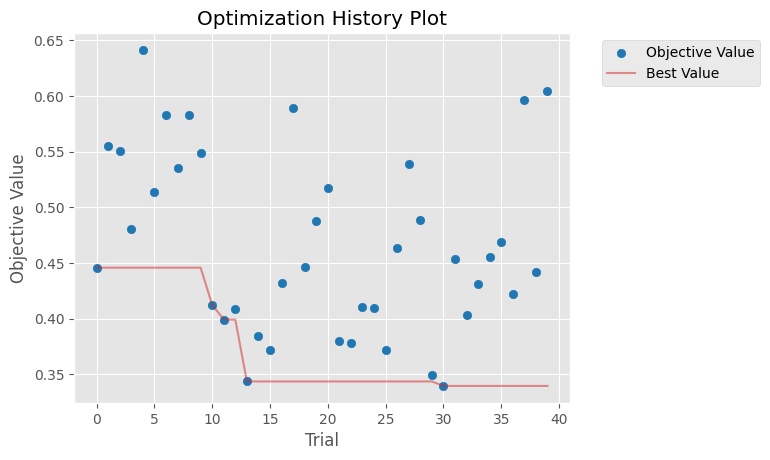

In [13]:
import optuna.visualization.matplotlib as opplt
opplt.plot_optimization_history(study)

/tmp/ipykernel_18/2166294799.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  opplt.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

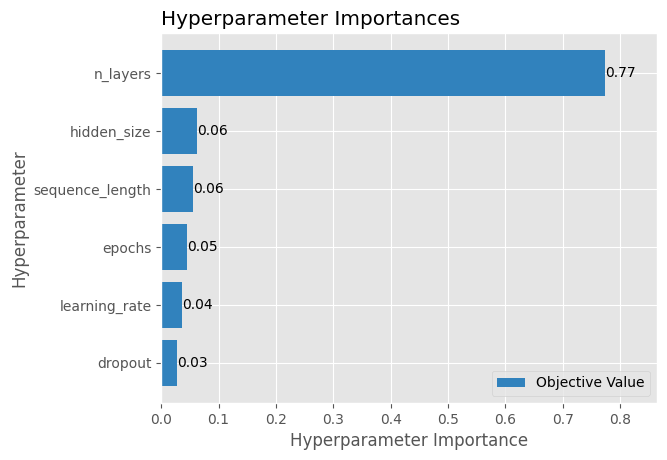

In [14]:
opplt.plot_param_importances(study)

/tmp/ipykernel_18/1591831254.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  opplt.plot_slice(study, params=['dropout', 'sequence_length', 'hidden_size', 'learning_rate', 'epochs', 'n_layers'])


array([<Axes: xlabel='dropout', ylabel='Objective Value'>,
       <Axes: xlabel='epochs'>, <Axes: xlabel='hidden_size'>,
       <Axes: xlabel='learning_rate'>, <Axes: xlabel='n_layers'>,
       <Axes: xlabel='sequence_length'>], dtype=object)

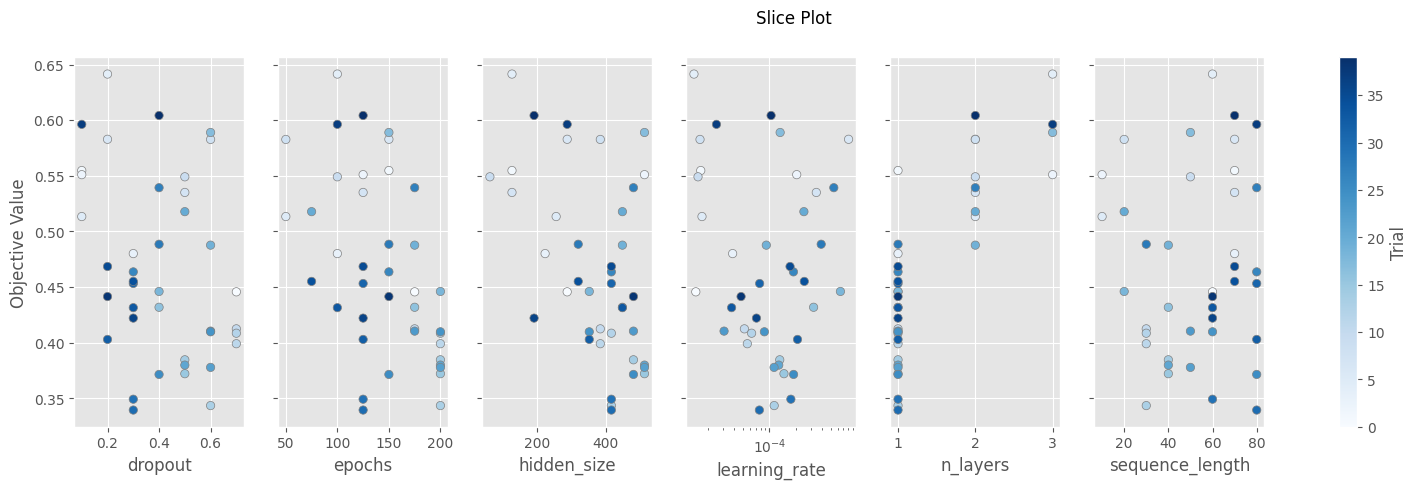

In [15]:
opplt.plot_slice(study, params=['dropout', 'sequence_length', 'hidden_size', 'learning_rate', 'epochs', 'n_layers'])